# Telecom Churn Case Study

#### Importing required libraries and modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA,IncrementalPCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('telecom_churn_data.csv')

In [3]:
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


### Filter High Value Customers
First we will filter the High Value Customer data as per the given rules to reduce the dataset

In [4]:
#Checking if there are any null values for 'Total Recharge Amount' for month 6 and month 7 as we will be using these for
#identifying High-Value-Customer(HVC)
print(data['total_rech_amt_6'].isnull().any())
print(data['total_rech_amt_7'].isnull().any())

False
False


In [5]:
data['avg_total_rech_amt_6_7'] = (data['total_rech_amt_6'] + data['total_rech_amt_7'])/2
print(data['avg_total_rech_amt_6_7'].isnull().any())

False


In [6]:
#Calculating 70th percentile for Average Total Recharge Amount for Month 6 and Month 7
avg_rech_amt_70th_perc=data['avg_total_rech_amt_6_7'].quantile(0.7) 

In [7]:
#Filtering for High Value Customers
data_hvc = data[data['avg_total_rech_amt_6_7']>avg_rech_amt_70th_perc]

In [8]:
# High value Customer data
data_hvc.shape

(29979, 227)

### Generate Churn Indicator column
New column churn_indi is created as per the given rules

In [9]:
#Preparing column for Churn/Non-Churn
#Checking total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9 for the presence of null values
print(data_hvc['total_ic_mou_9'].isnull().values.any())
print(data_hvc['total_og_mou_9'].isnull().values.any())
print(data_hvc['vol_2g_mb_9'].isnull().values.any())
print(data_hvc['vol_3g_mb_9'].isnull().values.any())

False
False
False
False


In [10]:
# function to return churn value
def churn_indicator(x):
    if(x.loc['total_ic_mou_9']==0.00 and x.loc['total_og_mou_9']==0.00 and x.loc['vol_2g_mb_9']==0.00 and x.loc['vol_3g_mb_9']==0.00):
        return 1
    else:
        return 0
    return

In [11]:
data_hvc['churn_indi'] = data_hvc.apply(churn_indicator, axis = 1)

In [12]:
data_hvc[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9','churn_indi']].head()

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9,churn_indi
7,0.00,0.00,0.0,0.0,1
8,34.91,142.18,0.0,0.0,0
13,631.86,446.09,0.0,0.0,0
16,334.56,255.74,0.0,0.0,0
17,87.13,631.08,0.0,0.0,0


### Drop columns for 9th month data
We can see that the churn_indi is created in data_hvc, 1 indicates churned customer and 0 represents non-churned customer,
We will drop columns which belong to Churn Phase i.e. ending with '_9'

In [13]:
churnPhaseCols = []
for col in data_hvc.columns:
    if(col.endswith('_9')):
        churnPhaseCols.append(col)

print(churnPhaseCols)
        

['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9']


In [14]:
data_hvc.drop(columns = churnPhaseCols, inplace = True)


### So now we have dataset in which
#### 1. we have identified the High-Value-Customer
#### 2. we have created the churn_indi column
#### 3. we have removed the columns which belong to Churn Phase i.e. ending with '_9'

In [15]:
data_hvc.shape

(29979, 174)

### Data Cleansing

In [16]:
# To get the columns which have only one valid values, i.e no variance
# The columns with same data for each row doesn't contribute to the model and can be dropped
def getSingleValuedColumns(data):
    listOfSingleCounts = []
    for i in data.columns:
        if data[i].value_counts().shape[0] == 1:
            listOfSingleCounts.append(i)
    return listOfSingleCounts

#List of Columns which have only one value
listOfSingleValuedColumns = getSingleValuedColumns(data_hvc)
#Dropping the columns with only one value as these are irrelevant for prediction
data_hvc.drop(columns = listOfSingleValuedColumns, inplace = True)
data_hvc.shape

(29979, 161)

In [17]:
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [18]:
# Dropping all columns containing date values as no useful inference can be drawn from those.
# Dropping column mobile_number as this is not required.
data_hvc.drop(columns= list(data_hvc.columns[data_hvc.columns.str.contains("date")]), inplace=True)
data_hvc.drop(columns=['mobile_number'],inplace = True)

In [19]:
# Imputing 0 to columns with NaN values
data_hvc=data_hvc.fillna(0)

In [20]:
data_hvc.reset_index(inplace=True)

In [21]:
data_hvc.set_index(pd.Index(range(data_hvc.shape[0])),inplace=True)

In [22]:
data_hvc.head()

,index,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_total_rech_amt_6_7,churn_indi
0,7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,802,57.74,19.38,18.74,0.0,1185.0,1
1,8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,0.0,19.83,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,0.0,1.0,1.0,315,21.03,910.65,122.16,0.0,519.0,0
2,13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,5

### Derived Metrics
#### Here we have dervied 5 new metrics based on the concept of trend.
#### a)total_ic_trend_678
#### b)total_og_trend_678
#### c)total_rech_amt_trend_678
#### d)total_rech_data_trend_678
#### e)total_rech_num_trend_678

#### For the corresponding values for the month 6,7 and 8 respectively
#### a) If values are steadily increasing trend is 3
#### b) If values increase from month 6 to 7 and then decrease from month 7 to 8 then trend is -1
#### c) If values decrease from month 6 to 7 and then increase from month 7 to 8 then trend is 1
#### d) If values are steadily increasing trend is 3

In [23]:
# The trend function 
# takes input a list of series and outputs a series of their trend values
def getTrend(values):
    trend = pd.Series(0,index=range(0,values[0].size))
    for i, val in enumerate(values[1:]):
       idx=i+1
       for j, trend_val in enumerate(values[idx].gt(values[idx-1])):
        if(trend_val):
            trend[j]+=idx
        else:
            trend[j]-=idx
    
    return trend

In [24]:
data_hvc['total_ic_trend_678']=getTrend([data_hvc['total_ic_mou_6'],data_hvc['total_ic_mou_7'],data_hvc['total_ic_mou_8']])

In [25]:
data_hvc['total_og_trend_678']=getTrend([data_hvc['total_og_mou_6'],data_hvc['total_og_mou_7'],data_hvc['total_og_mou_8']])

In [26]:
data_hvc['total_rech_amt_trend_678']=getTrend([data_hvc['total_rech_amt_6'],data_hvc['total_rech_amt_7'],data_hvc['total_rech_amt_8']])

In [27]:
data_hvc['total_rech_data_trend_678']=getTrend([data_hvc['total_rech_data_6'],data_hvc['total_rech_data_7'],data_hvc['total_rech_data_8']])

In [28]:
data_hvc['total_rech_num_trend_678']=getTrend([data_hvc['total_rech_num_6'],data_hvc['total_rech_num_7'],data_hvc['total_rech_num_8']])

In [29]:
data_hvc[['total_ic_trend_678','total_og_trend_678','total_rech_amt_trend_678','total_rech_data_trend_678','total_rech_num_trend_678']]=data_hvc[['total_ic_trend_678','total_og_trend_678','total_rech_amt_trend_678','total_rech_data_trend_678','total_rech_num_trend_678']].fillna(0)

In [30]:
pred_vars=data_hvc[data_hvc.columns[data_hvc.columns.str.contains("trend")]]
pred_vars['churn_indi']=data_hvc['churn_indi']
pred_vars.head()
pred_vars=pred_vars[pred_vars['churn_indi']==1]
pred_vars.head()

def getTrendName(trend_val):
    trend_map={-3:'Straight Decline',-1:'Decline 7 to 8',1:'Rise 7 to 8',3:'Straight Rise'}
    return trend_map[trend_val]

pred_vars[['total_ic_trend_678','total_og_trend_678','total_rech_data_trend_678','total_rech_amt_trend_678','total_rech_num_trend_678']]=pred_vars[['total_ic_trend_678','total_og_trend_678','total_rech_data_trend_678','total_rech_amt_trend_678','total_rech_num_trend_678']].applymap(lambda x: getTrendName(x))

ic_trend_count=pd.DataFrame(pred_vars['total_ic_trend_678'].value_counts().reset_index())
ic_trend_count.columns=['trend','ic_churn_count']
og_trend_count=pd.DataFrame(pred_vars['total_og_trend_678'].value_counts().reset_index())
og_trend_count.columns=['trend','og_churn_count']
data_trend_count=pd.DataFrame(pred_vars['total_rech_data_trend_678'].value_counts().reset_index())
data_trend_count.columns=['trend','data_churn_count']
rech_amt_trend_count=pd.DataFrame(pred_vars['total_rech_amt_trend_678'].value_counts().reset_index())
rech_amt_trend_count.columns=['trend','rech_amt_churn_count']
rech_trend_count=pd.DataFrame(pred_vars['total_rech_num_trend_678'].value_counts().reset_index())
rech_trend_count.columns=['trend','rech_churn_count']
pred_vars.head()

,total_ic_trend_678,total_og_trend_678,total_rech_amt_trend_678,total_rech_data_trend_678,total_rech_num_trend_678,churn_indi
0,Straight Decline,Decline 7 to 8,Rise 7 to 8,Straight Decline,Rise 7 to 8,1
23,Decline 7 to 8,Straight Decline,Straight Decline,Straight Decline,Decline 7 to 8,1
28,Straight Decline,Straight Decline,Straight Decline,Straight Decline,Straight Decline,1
35,Straight Decline,Straight Decline,Straight Decline,Straight Decline,Straight Decline,1
51,Straight Decline,Straight Decline,Straight Decline,Straight Decline,Straight Decline,1


### Using the derived metrics we find a very consistent pattern that clearly shows the signs when a customer is about to churn.
### In the below plots we can clearly see, the customers who have shown a steady decline in their call, data usage and also recharge frequency and recharge amount are among the highest in churning.

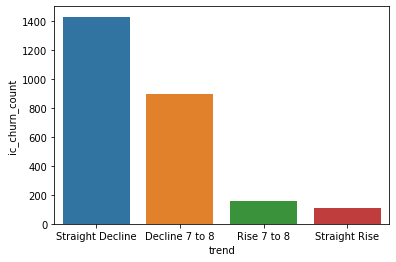

In [31]:
sns.barplot(x='trend',y='ic_churn_count',data=ic_trend_count)

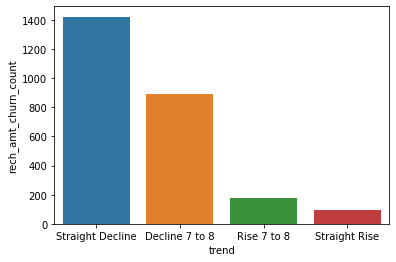

In [32]:
sns.barplot(x='trend',y='rech_amt_churn_count',data=rech_amt_trend_count)

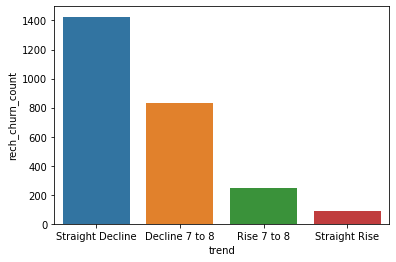

In [33]:
sns.barplot(x='trend',y='rech_churn_count',data=rech_trend_count)

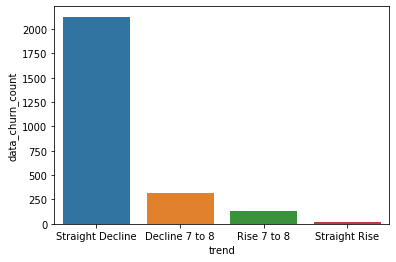

In [34]:
sns.barplot(x='trend',y='data_churn_count',data=data_trend_count)

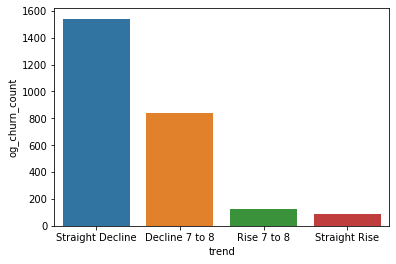

In [35]:
sns.barplot(x='trend',y='og_churn_count',data=og_trend_count)

### Extract train and test data

In [36]:
X=data_hvc[data_hvc.columns[data_hvc.columns != 'churn_indi']]
Y=data_hvc[data_hvc.columns[data_hvc.columns == 'churn_indi']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

### Scaling data

In [37]:
scaler=MinMaxScaler()
X_train[X_train.columns[~(X_train.columns.str.contains("trend"))]]=scaler.fit_transform(X_train[X_train.columns[~(X_train.columns.str.contains("trend"))]])
X_test[X_test.columns[~(X_test.columns.str.contains("trend"))]]=scaler.transform(X_test[X_test.columns[~(X_test.columns.str.contains("trend"))]])

### Model Creation
We will start with Logistic Regression and then move to Random Forest Classifier and then compare the recall values, 
since the telecom company is more focussed on predicting the customers with high risk of churn.
Next we will move to Dimension Reduction strategy using PCA and then apply the regression techniques.
Finally we will conclude the results.

In [38]:
linear_model=LogisticRegression(n_jobs=-1,random_state=5,verbose=1000,class_weight='balanced',C=10)
linear_model.fit(X_train,Y_train)
Y_pred=linear_model.predict(X_test)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

[LibLinear]              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8207
           1       0.31      0.81      0.45       787

    accuracy                           0.82      8994
   macro avg       0.64      0.82      0.67      8994
weighted avg       0.92      0.82      0.86      8994



In [39]:
parameters={'C':[5,8,10,50,100,110,120,130]}
gridcv=GridSearchCV(linear_model,parameters,verbose=10,n_jobs=-1)
gridcv.fit(X_train,Y_train)
best_rfc=gridcv.best_estimator_
Y_pred=best_rfc.predict(X_test)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:   11.7s remaining:   58.8s
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:   12.2s remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:   15.8s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:   23.7s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:   24.5s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:   25.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   26.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   27.4s finished


[LibLinear]              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8207
           1       0.31      0.82      0.45       787

    accuracy                           0.83      8994
   macro avg       0.65      0.82      0.67      8994
weighted avg       0.92      0.83      0.86      8994



### Using Linear Regression we get a recall of 45%
Lets move to Random Forest Classifier

In [40]:
RFC_model=RandomForestClassifier(n_jobs=-1,random_state=5,verbose=1000,class_weight='balanced_subsample')
RFC_model.fit(X_train,Y_train)
Y_pred=RFC_model.predict(X_test)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 10building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10

building tree 7 of 10
building tree 8 of 10building tree 9 of 10

building tree 10 of 10
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remain

In [41]:
parameters={'max_depth':[5,8,10,20,22],'max_leaf_nodes':[10,15,20,25,30]}
gridcv=GridSearchCV(RFC_model,parameters,verbose=10,n_jobs=-1)
gridcv.fit(X_train,Y_train)
gridcv.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    7.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:    8.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 10
building tree 2 of 10building tree 3 of 10

building tree 4 of 10
building tree 5 of 10
building tree 6 of 10building tree 7 of 10

building tree 8 of 10building tree 9 of 10
building tree 10 of 10

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s remain

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=30, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=5, verbose=1000, warm_start=False)

In [42]:
gridcv.best_params_
best_rfc=gridcv.best_estimator_
Y_pred=best_rfc.predict(X_test)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      8207
           1       0.47     

### Random Forest Classifier shows a recall percentage of 71%, which is higher than Logistic Regression
Now we move to Dimensionality reduction using PCA, as we can reduce the no of features significantly using PCA

In [43]:
pca_transform=PCA(svd_solver='randomized',random_state=42)
pca_transform.fit_transform(X_train)

array([[ 1.97809133e+00,  1.65752187e-01, -2.10312151e+00, ...,
         1.83340541e-15, -1.07287699e-15,  1.03391227e-15],
       [ 1.97232689e+00,  2.35625470e+00,  1.90663512e-01, ...,
        -3.01948345e-15,  3.01111998e-15, -1.67291698e-15],
       [ 8.19026333e-01,  5.44309664e-01, -1.37578089e+00, ...,
         7.31873868e-16, -5.12173696e-16,  7.43321310e-16],
       ...,
       [ 3.58463980e+00,  5.62363662e+00,  2.79071443e+00, ...,
         4.18429483e-17, -8.27874575e-17, -1.44596113e-17],
       [ 2.81502236e+00, -2.57812411e+00, -8.85387134e-02, ...,
        -8.32344176e-17, -1.46640275e-16,  3.28135380e-16],
       [ 6.70850878e+00, -4.25590558e-01, -9.57566762e-01, ...,
        -5.92802064e-17,  2.31417970e-16,  1.07245813e-16]])

### Making the screeplot - plotting the cumulative variance against the number of components
We can see that within 23 features, the variance reaches the maximum value

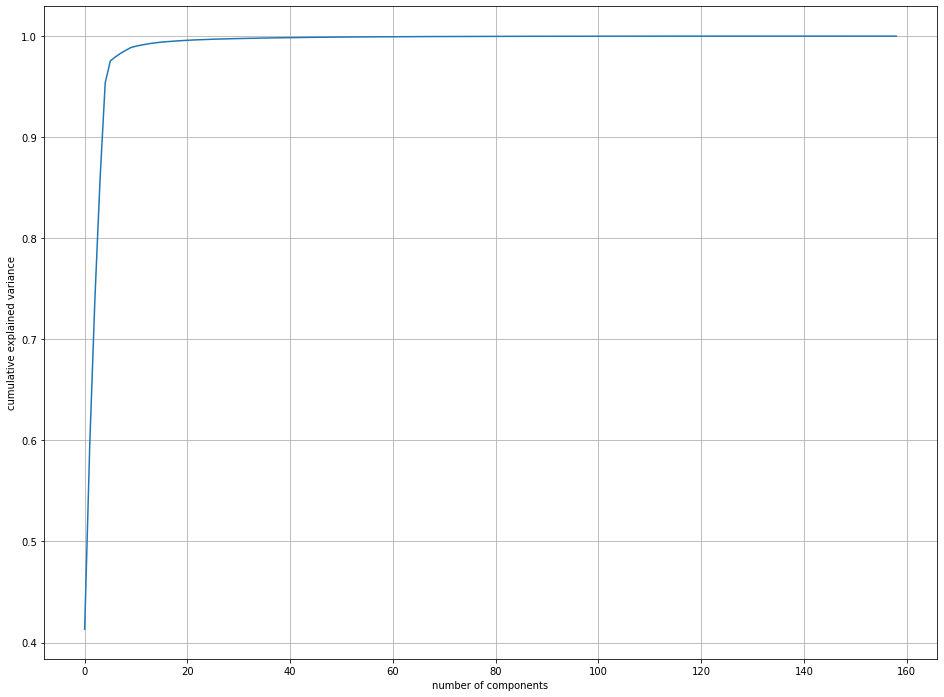

In [44]:
%matplotlib inline
fig = plt.figure(figsize = (16,12))
plt.plot(np.cumsum(pca_transform.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

### Now we finalize the PCA model with 23 features

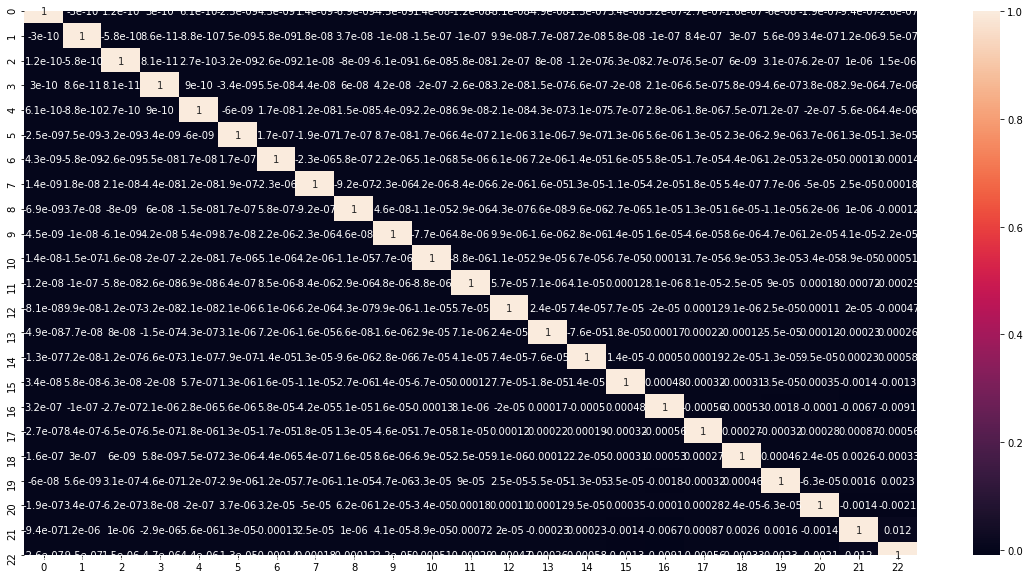

In [45]:
pca_final = IncrementalPCA(n_components=23)
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape
corrmat = np.corrcoef(df_train_pca.transpose())
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [46]:
#Applying selected components to the test data - 30 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8994, 23)

# Using RandomForest with PCA

In [47]:
#Training the model on the train data
learner_pca = RandomForestClassifier(n_jobs=-1,random_state=42,verbose=1000,class_weight='balanced',max_depth=3,max_leaf_nodes=10)
model_pca = learner_pca.fit(df_train_pca,Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10building tree 5 of 10

building tree 6 of 10
building tree 7 of 10
building tree 8 of 10building tree 9 of 10
building tree 10 of 10

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remain

In [48]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(Y_test, pred_probs_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


'0.82'

In [49]:
y_pred = model_pca.predict(df_test_pca)
print(accuracy_score(Y_test, y_pred, normalize=False))
print(classification_report(Y_test, y_pred, labels=[0,1]))
#print(accuracy_score(Y_test, pred_probs_test, normalize=False))
confusion_matrix(Y_test,y_pred)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
7097
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      8207
           1       0.26

array([[6513, 1694],
       [ 203,  584]], dtype=int64)

#### We can see that the Recall for Churn prediction has increased from 71% to 74% when we use RandomForest with PCA which is an improvement to our old score without PCA

# Using Ridge Classifier with PCA

In [50]:
ridge_model=RidgeClassifier(class_weight='balanced',alpha=1e3)
ridge_model.fit(df_train_pca,Y_train)
Y_pred=ridge_model.predict(df_test_pca)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      8207
           1       0.22      0.81      0.35       787

    accuracy                           0.73      8994
   macro avg       0.60      0.77      0.59      8994
weighted avg       0.91      0.73      0.79      8994



#### We can see that the Recall for Churn prediction has increased from 74% to 81% when we use Ridge Classifier with PCA which is an improvement to our old score

# Using SGD Classifier with PCA

In [51]:
sgd_model=SGDClassifier(penalty='elasticnet',class_weight='balanced',alpha=4.0e-6,random_state=42)
sgd_model.fit(df_train_pca,Y_train)
Y_pred=sgd_model.predict(df_test_pca)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.58      0.73      8207
           1       0.17      0.88      0.28       787

    accuracy                           0.61      8994
   macro avg       0.57      0.73      0.51      8994
weighted avg       0.91      0.61      0.69      8994



#### We can see that the Recall for Churn prediction has increased from 81% to 88% when we use SGD Classifier with PCA which is an improvement to our old score

# Using Logistic Regression with PCA and Hyperparameter Tunning using GridSearchCV

In [52]:
#from sklearn.preprocessing import StandardScaler
#scaler=StandardScaler()
scaler = MinMaxScaler()
X_scaled=(scaler.fit_transform(X[X.columns[~(X.columns.str.contains("trend"))]]))
print(type(X_scaled))
X_scaled = pd.DataFrame(X_scaled,columns=X.columns[~(X.columns.str.contains("trend"))])
X_trend = X[X.columns[(X.columns.str.contains("trend"))]]
print(type(X_scaled))
print(type(X_trend))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [53]:
X_scaled = pd.concat([X_scaled, X_trend],axis=1)
X_scaled.drop(columns=['index'],inplace = True)

In [54]:
pca_transform=PCA(svd_solver='randomized',random_state=42)
pca_transform.fit_transform(X_scaled)

array([[-1.46210335e-01,  2.90228935e+00, -2.09811542e+00, ...,
        -1.67205815e-15,  3.89412837e-15, -1.56673210e-16],
       [-2.29867184e+00,  4.24184792e+00,  3.14107206e+00, ...,
        -1.92387800e-16,  9.47880161e-16,  1.04430571e-15],
       [ 3.36543299e+00,  1.41461448e+00,  1.82699731e+00, ...,
        -4.06991201e-15,  1.62779962e-14,  1.84243997e-15],
       ...,
       [ 1.79419239e+00, -3.07973528e+00,  6.54070349e-01, ...,
        -2.41926130e-16,  7.34480911e-17, -3.45656166e-17],
       [-8.03825786e-01, -1.48895838e+00,  1.49886250e+00, ...,
        -1.49616161e-16, -1.64014507e-16, -2.17473735e-16],
       [-6.25836462e-01,  2.70755207e+00,  2.42616983e+00, ...,
         2.93616794e-17, -3.30211670e-16, -1.71942632e-16]])

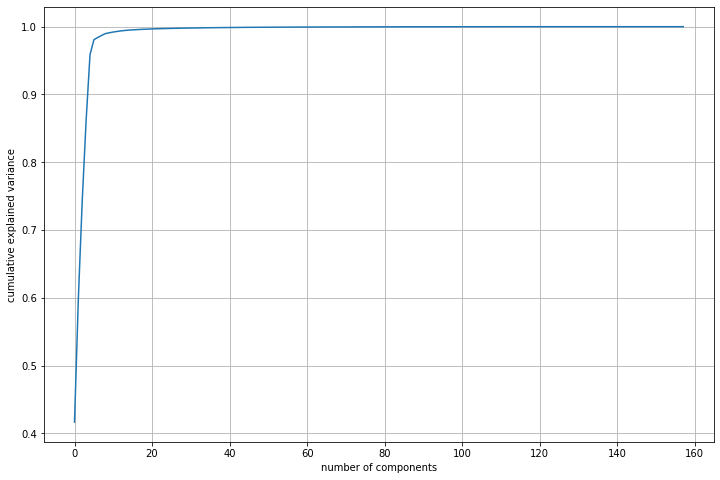

In [55]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca_transform.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

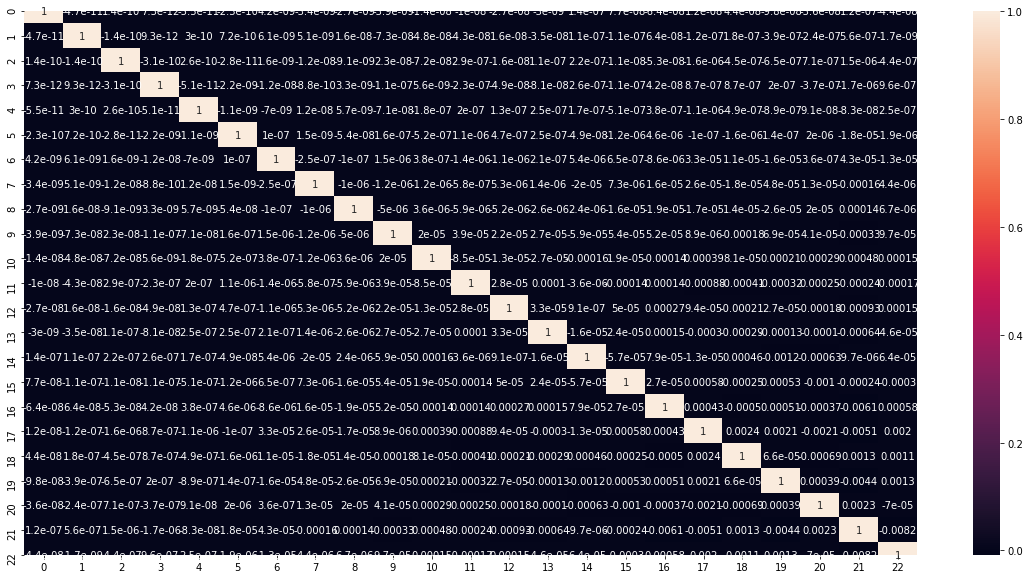

In [56]:
pca_final = IncrementalPCA(n_components=23)
df_pca = pca_final.fit_transform(X_scaled)
df_pca.shape
corrmat = np.corrcoef(df_pca.transpose())
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [57]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 107)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'C': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]}]


# specify model
model = LogisticRegression(class_weight='balanced')

# set up GridSearchCV()

model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
#                         scoring= ['balanced_accuracy','f1','precision','recall'],
                        scoring= ['precision','recall'],
                        n_jobs = -1,
                        cv = folds, 
                        verbose = 1000,
                        refit='recall',
                        return_train_score=True)      

# fit the model
model_cv.fit(df_pca, Y)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
Memmapping (shape=(29979, 23), dtype=float64) to new file C:\Users\i353877\AppData\Local\Temp\joblib_memmapping_folder_15704_7843018943\15704-1866416971720-2f5ac140469942548ce81dd4fe41cd32.pkl
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(1, 29979), dtype=int64).
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(23983,), dtype=int32).
Pickling array (shape=(5996,), dtype=int32).
Memmapping (shape=(29979, 23), dtype=float64) to old file C:\Users\i353877\AppData\Local\Temp\joblib_memmapping_folder_15704_7843018943\15704-1866416971720-2f5ac140469942548ce81dd4fe41cd32.pkl
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(1, 29979), dtype=int64).
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(23983,), dtype=int32).
Pickling array (shape=(5996,), dtype=int32).
Memmapping (shape=(29979, 

GridSearchCV(cv=KFold(n_splits=5, random_state=107, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                1e-07, 1e-08, 1e-09, 1e-10]}],
             pre_dispatch='2*n_jobs', refit='recall', return_train_score=True,
             scoring=['precision', 'recall'], verbose=1000)

In [58]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall
0,1.119481,0.043286,0.038398,0.008343,1,{'C': 1},0.244818,0.228824,0.238385,0.244743,0.231167,0.237588,0.006665,1,0.236857,0.243313,0.238918,0.237358,0.240995,0.239488,0.002395,0.798903,0.779559,0.824092,0.828063,0.782101,0.802544,0.020372,11,0.807542,0.809569,0.803485,0.802208,0.812530,0.807067,0.003815
1,0.984908,0.071516,0.035785,0.009163,0.1,{'C': 0.1},0.242778,0.226558,0.237700,0.243493,0.231735,0.236453,0.006501,2,0.236579,0.242303,0.236426,0.235477,0.239569,0.238071,0.002523,0.798903,0.779559,0.822180,0.832016,0.789883,0.804509,0.019681,10,0.811459,0.813397,0.803001,0.801728,0.813494,0.808616,0.005171
2,0.653698,0.076574,0.026466,0.009921,0.01,{'C': 0.01},0.233820,0.218630,0.229665,0.230643,0.218260,0.226204,0.006483,3,0.224465,0.229882,0.226215,0.226233,0.229795,0.227318,0.002156,0.819013,0.799599,0.826004,0.835968,0.785992,0.813316,0.018118,9,0.816846,0.820096,0.813650,0.812290,0.822169,0.817010,0.003734
3,0.410830,0.023864,0.017282,0.002429,0.001,{'C': 0.001},0.202763,0.190717,0.199091,0.200750,0.189687,0.196602,0.005363,4,0.194336,0.198085,0.196402,0.195308,0.197936,0.196413,0.001459,0.831810,0.831663,0.837476,0.845850,0.801556,0.829672,0.014977,8,0.830069,0.831579,0.824298,0.823332,0.831807,0.828217,0.003656
4,0.276257,0.033338,0.016694,0.004756,0.0001,{'C': 0.0001},0.169939,0.160629,0.167459,0.169040,0.158258,0.165065,0.004718,5,0.163181,0.165864,0.165212,0.164277,0.166332,0.164973,0.001131,0.870201,0.879760,0.875717,0.891304,0.848249,0.873047,0.014202,7,0.875122,0.873206,0.870281,0.868939,0.878554,0.873220,0.003436
5,0.221082,0.021827,0.015996,0.005442,1e-05,{'C': 1e-05},0.158927,0.147525,0.153462,0.154570,0.148541,0.152605,0.004169,6,0.150901,0.153961,0.152446,0.152213,0.153451,0.152594,0.001062,0.888483,0.895792,0.881453,0.909091,0.871595,0.889283,0.012724,6,0.889814,0.888995,0.891578,0.884782,0.893494,0.889733,0.002919
6,0.161048,0.014351,0.014663,0.002398,1e-06,{'C': 1e-06},0.157419,0.145928,0.151545,0.152368,0.147068,0.150866,0.004110,7,0.149090,0.152409,0.150575,0.150689,0.151711,0.150895,0.001128,0.892139,0.897796,0.881453,0.909091,0.873541,0.890804,0.012414,1,0.890304,0.889952,0.893030,0.886702,0.895422,0.891082,0.002956
7,0.123200,0.015622,0.013949,0.002943,1e-07,{'C': 1e-07},0.157387,0.145881,0.150820,0.152066,0.146780,0.150587,0.004126,8,0.148679,0.152297,0.150424,0.150432,0.151483,0.150663,0.001216,0.893967,0.897796,0.879541,0.909091,0.873541,0.890788,0.012792,2,0.889814,0.889952,0.893514,0.886702,0.895904,0.891177,0.003200
8,0.134951,0.012128,0.020660,0.004953,1e-08,{'C': 1e-08},0.157336,0.145833,0.150820,0.152016,0.146636,0.150528,0.004143,9,0.148642,0.152272,0.150411,0.150419,0.151458,0.150641,0.001219,0.893967,0.897796,0.879541,0.909091,0.873541,0.890788,0.012792,2,0.889814,0.889952,0.893514,0.886702,0.895904,0.891177,0.003200
9,0.122473,0.009686,0.018142,0.010025,1e-09,{'C': 1e-09},0.157336,0.145833,0.150820,0.152016,0.146636,0.150528,0.004143,9,0.148642,0.152272,0.150411,0.150419,0.151458,0.150641,0.001219,0.893967,0.897796,0.879541,0.909091,0.873541,0.890788,0.012792,2,0.889814,0.889952,0.893514,0.886702,0.895904,0.891177,0.003200


In [59]:
#Best model Recall Score
print(model_cv.best_score_)

0.890804466007768


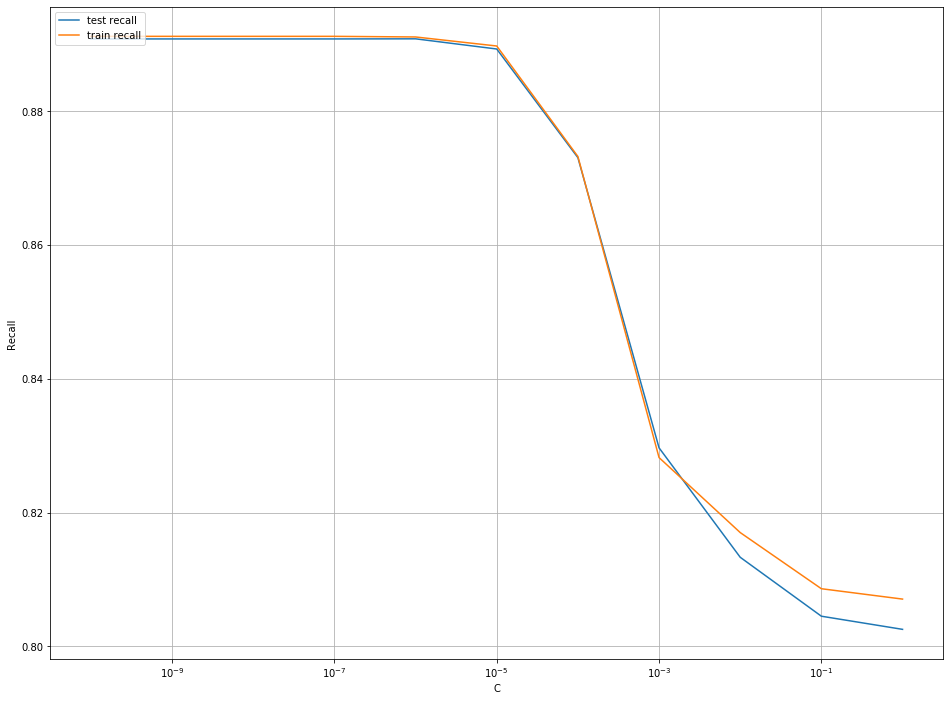

In [60]:
#Plotting Test & Train Recall Score
cv_results['param_C'] = cv_results['param_C']

# # plotting
plt.figure(figsize=(16,12))

plt.plot(cv_results["param_C"], cv_results["mean_test_recall"])
plt.plot(cv_results["param_C"], cv_results["mean_train_recall"])
plt.xlabel('C')
plt.ylabel('Recall')
plt.grid()
plt.legend(['test recall', 'train recall'], loc='upper left')
plt.xscale('log')

In [61]:
best_model=model_cv.best_estimator_
Y_pred=best_model.predict(df_test_pca)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.53      0.69      8207
           1       0.15      0.87      0.26       787

    accuracy                           0.56      8994
   macro avg       0.56      0.70      0.47      8994
weighted avg       0.91      0.56      0.65      8994



In [62]:
print(best_model)

LogisticRegression(C=1e-06, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


### We can see that the best model for GridSearch is with C = 1e-06, the model's mean test recall is 89.0804% which is more than 88%(our last best recall using SGD Classifier), this is represented above using Graph plot as well as tabular representation for comparison. So we consider Logistic Regression(with Hyperparameter C = 1e-6) with PCA(with 23 components) as the best model

##### We have also found the most important variables that are strong predictors of churn. These are derived features and we have already plotted relevant graph in this solution python file which shows a clear trend for Churn.
##### These derived features are:
##### 1. total_ic_trend_678
##### 2. total_og_trend_678
##### 3. total_rech_amt_trend_678
##### 4. total_rech_data_trend_678
##### 5. total_rech_num_trend_678

##### Recommendation :: We recommend that if a customer has a decreasing trend in any of the above mentioned five features then it is an indicator that customer might Churn. So decreasing trend on more of these features, would mean higher chance of customer being Churning.
##### So Business can give lucrative offers to these customers to retain them. 